Epoch 1: Loss = 0.749020
✅ 当前为最优模型，已保存至：checkpoints/best_swinunet_model.pth
Epoch 2: Loss = 0.749126
Epoch 3: Loss = 0.749009
✅ 当前为最优模型，已保存至：checkpoints/best_swinunet_model.pth
Epoch 4: Loss = 0.749116
Epoch 5: Loss = 0.749082
✅ 已保存：./inpainted_results/inpainted_ISIC2019_0000461.jpg


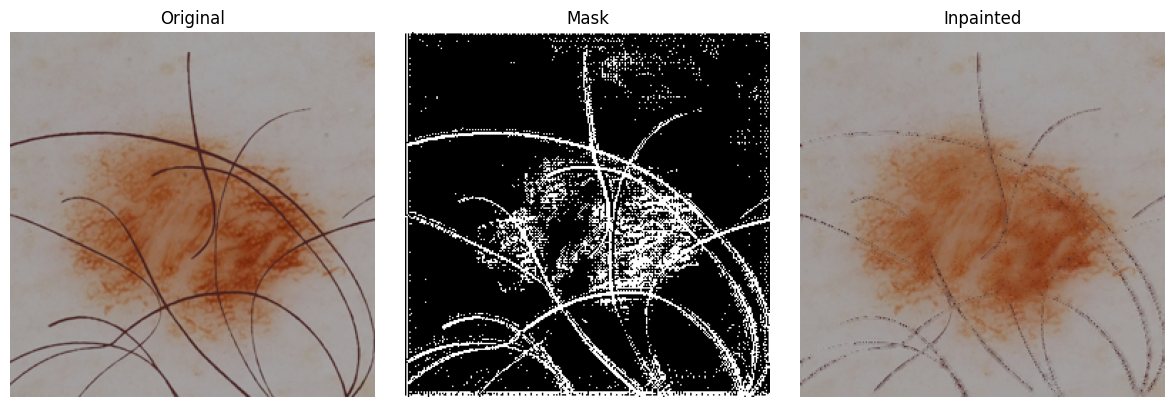

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0031696.jpg


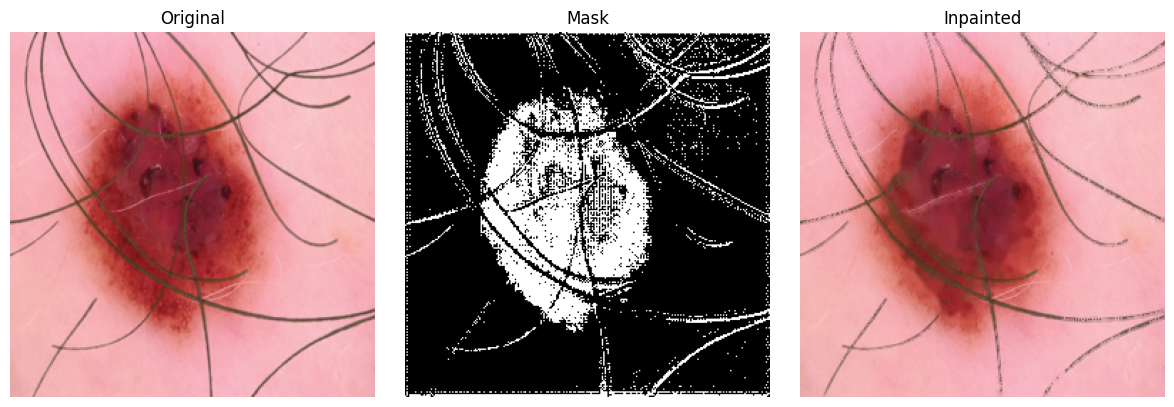

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0028326.jpg


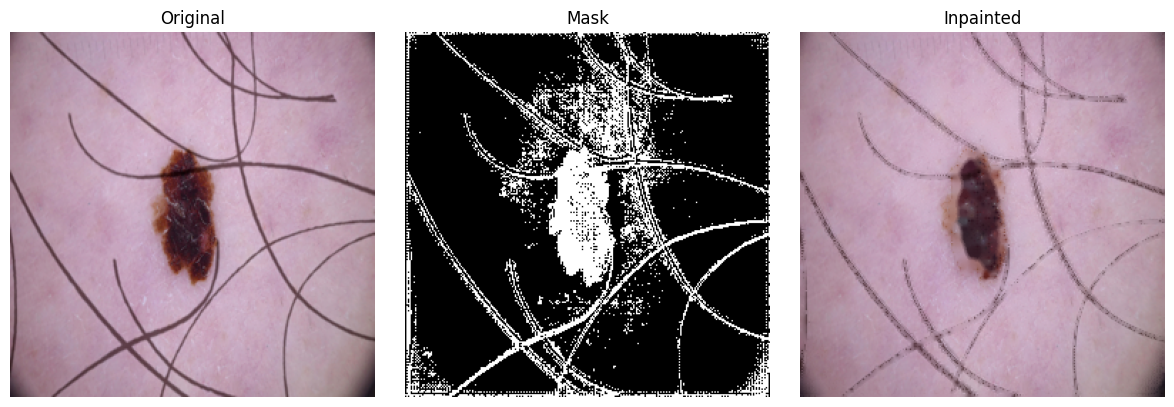

✅ ISIC2017_0000026.jpg  |  MSE: 0.0039  PSNR: 24.07  SSIM: 0.9220  UQI: 0.9990
✅ ISIC2017_0000081.jpg  |  MSE: 0.0007  PSNR: 31.26  SSIM: 0.8337  UQI: 0.9986
✅ ISIC2017_0000082.jpg  |  MSE: 0.0014  PSNR: 28.69  SSIM: 0.8331  UQI: 0.9930
✅ ISIC2017_0000147.jpg  |  MSE: 0.0015  PSNR: 28.18  SSIM: 0.8421  UQI: 0.9950
✅ ISIC2017_0000150.jpg  |  MSE: 0.0014  PSNR: 28.69  SSIM: 0.8278  UQI: 0.9897
✅ ISIC2017_0000151.jpg  |  MSE: 0.0009  PSNR: 30.43  SSIM: 0.8637  UQI: 0.9925
✅ ISIC2017_0000152.jpg  |  MSE: 0.0014  PSNR: 28.47  SSIM: 0.8169  UQI: 0.9864
✅ ISIC2017_0000153.jpg  |  MSE: 0.0016  PSNR: 28.06  SSIM: 0.8043  UQI: 0.9959
✅ ISIC2017_0000154.jpg  |  MSE: 0.0022  PSNR: 26.62  SSIM: 0.7910  UQI: 0.9902
✅ ISIC2017_0001148.jpg  |  MSE: 0.0008  PSNR: 30.78  SSIM: 0.8694  UQI: 0.9962
✅ ISIC2017_0012137.jpg  |  MSE: 0.0011  PSNR: 29.58  SSIM: 0.8405  UQI: 0.9951
✅ ISIC2017_0015079.jpg  |  MSE: 0.0021  PSNR: 26.71  SSIM: 0.7616  UQI: 0.9874
✅ ISIC2019_0000171.jpg  |  MSE: 0.0015  PSNR: 28.24 

In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from monai.networks.nets import SwinUNETR
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (
        pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return 1 - dice.mean()

class HairMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, img_name)).convert('L')
        if self.transform_img:
            img = self.transform_img(img)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        return img, mask

transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = HairMaskDataset(
    image_dir="/root/autodl-fs/skin_hair_dataset/alignment/photo with hair",
    mask_dir="/root/autodl-fs/skin_hair_dataset/alignment/mask",
    transform_img=transform_img,
    transform_mask=transform_mask
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinUNETR(
    img_size=(256, 256),
    in_channels=3,
    out_channels=1,
    feature_size=48,
    depths=(2, 2, 2, 2),
    num_heads=(3, 6, 12, 24),
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.1,
    use_checkpoint=False,
    spatial_dims=2
).to(device)

best_loss = float('inf')  # 初始化为正无穷
save_path = "checkpoints/best_swinunet_model.pth"
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(5):
    model.train()
    total_loss = 0.0

    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = dice_loss(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}: Loss = {avg_loss:.6f}")

    # ✅ 保存当前最优模型（loss 最低且大于 0）
    if 0 < avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ 当前为最优模型，已保存至：{save_path}")

def inpaint_image(image_path, save_path=None):
    model.eval()
    image = Image.open(image_path).convert("RGB").resize((256, 256))
    input_tensor = transform_img(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(input_tensor).squeeze().cpu().numpy()
    binary_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    inpainted = cv2.inpaint(image_cv, binary_mask, 3, cv2.INPAINT_TELEA)
    if save_path:
        cv2.imwrite(save_path, inpainted)
    return image_cv, binary_mask, inpainted
test_images = ['ISIC2019_0000461.jpg', 'ISIC2019_0031696.jpg', 'ISIC2019_0028326.jpg']
test_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
save_dir = "./inpainted_results"  # 保存目录

# 创建保存目录
os.makedirs(save_dir, exist_ok=True)

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    
    # 获取原图、掩码、修复图像
    original, mask, inpainted = inpaint_image(img_path)
    
    # 保存 inpainted 图像
    save_path = os.path.join(save_dir, f"inpainted_{img_name}")
    cv2.imwrite(save_path, inpainted)
    print(f"✅ 已保存：{save_path}")
    
    # 可视化显示
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)); plt.title("Inpainted"); plt.axis("off")
    plt.tight_layout(); plt.show()
def calculate_metrics(pred_img, gt_img):
    pred_img = pred_img.astype(np.float32) / 255.0
    gt_img = gt_img.astype(np.float32) / 255.0

    h, w = pred_img.shape[:2]
    win_size = min(7, h, w)
    if win_size % 2 == 0:
        win_size -= 1

    mse = mean_squared_error(gt_img, pred_img)
    psnr = peak_signal_noise_ratio(gt_img, pred_img, data_range=1.0)
    ssim = structural_similarity(gt_img, pred_img, data_range=1.0, channel_axis=2, win_size=win_size)
    uqi_val = uqi(gt_img, pred_img)

    return mse, psnr, ssim, uqi_val
image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
original_dir = "/root/autodl-fs/skin_hair_dataset/alignment/oryginal"  # 没有毛发的 ground-truth 原图
image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# 累加指标
total_mse, total_psnr, total_ssim, total_uqi = 0, 0, 0, 0
valid_count = 0

for img_name in image_list:
    try:
        # 推理修复图像
        img_path = os.path.join(image_dir, img_name)
        original, _, inpainted = inpaint_image(img_path)

        # 加载 ground-truth（无毛发）图像
        gt_path = os.path.join(original_dir, img_name)
        if not os.path.exists(gt_path):
            print(f"❌ ground-truth 缺失: {img_name}")
            continue
        gt_img = cv2.imread(gt_path)
        gt_img = cv2.resize(gt_img, (256, 256))

        # 计算指标
        mse, psnr, ssim, uqi_val = calculate_metrics(inpainted, gt_img)
        total_mse += mse
        total_psnr += psnr
        total_ssim += ssim
        total_uqi += uqi_val
        valid_count += 1
        print(f"✅ {img_name}  |  MSE: {mse:.4f}  PSNR: {psnr:.2f}  SSIM: {ssim:.4f}  UQI: {uqi_val:.4f}")
    except Exception as e:
        print(f"⚠️ 处理失败 {img_name}：{str(e)}")

# 平均指标打印
if valid_count > 0:
    print("\n📊 平均指标：")
    print(f"  MSE  : {total_mse / valid_count:.6f}")
    print(f"  PSNR : {total_psnr / valid_count:.2f} dB")
    print(f"  SSIM : {total_ssim / valid_count:.4f}")
    print(f"  UQI  : {total_uqi / valid_count:.4f}")
else:
    print("❌ 没有成功评估任何图像")
